# 时间序列(Time Series)预测 

## 载入相关套件 

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## 判断GPU是否存在

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入资料

In [27]:
df = pd.read_csv('./nlp_data/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [28]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


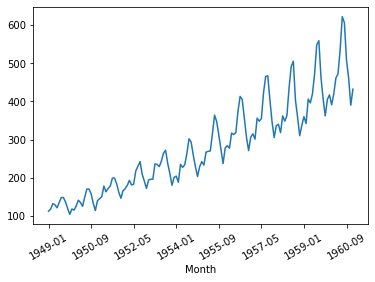

In [29]:
# 绘图
df2 = df.set_index('Month')
df2.plot(legend=None)
plt.xticks(rotation=30);

In [30]:
len(df2)

144

In [31]:
# 以前N期资料为 X，当期资料为 Y
look_back = 1 

# 转换资料
from sklearn.preprocessing import MinMaxScaler

# 函数：以前期资料为 X，当前期资料为 Y
def create_dataset(data1, look_back):
    x, y = [], []
    for i in range(len(data1)-look_back-1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back]
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

dataset = df2[['Passengers']].values
dataset = dataset.astype('float32')

# X 常态化
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# 资料分割
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
dataset.shape, trainY.shape

((144, 1), torch.Size([94, 1]))

In [32]:
dataset[-1]

array([0.6332046], dtype=float32)

In [33]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([94, 1, 1]),
 torch.Size([94, 1]),
 torch.Size([46, 1, 1]),
 torch.Size([46, 1]))

In [34]:
torch.cat((trainX.reshape(trainX.shape[0], trainX.shape[1]), trainY), axis=1)

tensor([[0.0154, 0.0270],
        [0.0270, 0.0541],
        [0.0541, 0.0483],
        [0.0483, 0.0328],
        [0.0328, 0.0598],
        [0.0598, 0.0849],
        [0.0849, 0.0849],
        [0.0849, 0.0618],
        [0.0618, 0.0290],
        [0.0290, 0.0000],
        [0.0000, 0.0270],
        [0.0270, 0.0212],
        [0.0212, 0.0425],
        [0.0425, 0.0714],
        [0.0714, 0.0598],
        [0.0598, 0.0405],
        [0.0405, 0.0869],
        [0.0869, 0.1274],
        [0.1274, 0.1274],
        [0.1274, 0.1042],
        [0.1042, 0.0560],
        [0.0560, 0.0193],
        [0.0193, 0.0695],
        [0.0695, 0.0792],
        [0.0792, 0.0888],
        [0.0888, 0.1429],
        [0.1429, 0.1139],
        [0.1139, 0.1313],
        [0.1313, 0.1429],
        [0.1429, 0.1834],
        [0.1834, 0.1834],
        [0.1834, 0.1544],
        [0.1544, 0.1120],
        [0.1120, 0.0811],
        [0.0811, 0.1197],
        [0.1197, 0.1293],
        [0.1293, 0.1467],
        [0.1467, 0.1718],
        [0.1

In [35]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(1, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        #print(x.shape)
        # rnn_out, h_out = self.rnn(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)        
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))
        #print(h_out.shape)
        
        # 取最后一层的h，并转成二维
        # flatten_output = h_out[-1].view(-1, self.hidden_size)  
        # 取最后一个输出，并转成二维
        flatten_output = out[:, -1].view(-1, self.hidden_size)  
        return self.fc(flatten_output)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)

## 模型训练

In [36]:
num_epochs = 2000
learning_rate = 0.01

def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)    
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

In [37]:
trainX.shape, trainY.shape

(torch.Size([94, 1, 1]), torch.Size([94, 1]))

In [38]:
train(trainX, trainY)

torch.Size([94, 1])
Epoch: 0, loss: 0.04234
Epoch: 100, loss: 0.00196
Epoch: 200, loss: 0.00191
Epoch: 300, loss: 0.00190
Epoch: 400, loss: 0.00190
Epoch: 500, loss: 0.00190
Epoch: 600, loss: 0.00190
Epoch: 700, loss: 0.00190
Epoch: 800, loss: 0.00190
Epoch: 900, loss: 0.00190
Epoch: 1000, loss: 0.00190
Epoch: 1100, loss: 0.00190
Epoch: 1200, loss: 0.00190
Epoch: 1300, loss: 0.00190
Epoch: 1400, loss: 0.00190
Epoch: 1500, loss: 0.00190
Epoch: 1600, loss: 0.00190
Epoch: 1700, loss: 0.00190
Epoch: 1800, loss: 0.00190
Epoch: 1900, loss: 0.00190


## 模型评估

In [39]:
model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()
trainPredict.shape

(94, 1)

In [40]:
trainY.shape, trainPredict.shape

(torch.Size([94, 1]), (94, 1))

In [41]:
from sklearn.metrics import mean_squared_error
import math 

# 还原常态化的训练及测试资料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 计算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(94, 1) (94, 1)
Train RMSE: 22.56
Test RMSE:  56.71


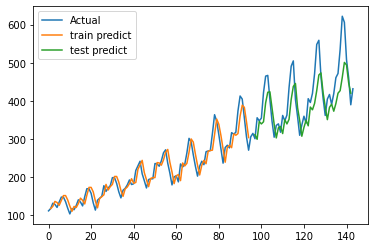

In [42]:
# 训练资料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:len(trainPredict)+look_back, :] = trainPredict

# 测试资料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 绘图
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## 改变Loopback=3：X由前1期改为前3期 

In [43]:
# 以前期资料为 X，当前期资料为 Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)
train(trainX, trainY)

torch.Size([92, 1])
Epoch: 0, loss: 0.07856
Epoch: 100, loss: 0.00350
Epoch: 200, loss: 0.00293
Epoch: 300, loss: 0.00240
Epoch: 400, loss: 0.00198
Epoch: 500, loss: 0.00177
Epoch: 600, loss: 0.00169
Epoch: 700, loss: 0.00166
Epoch: 800, loss: 0.00164
Epoch: 900, loss: 0.00162
Epoch: 1000, loss: 0.00160
Epoch: 1100, loss: 0.00158
Epoch: 1200, loss: 0.00156
Epoch: 1300, loss: 0.00155
Epoch: 1400, loss: 0.00154
Epoch: 1500, loss: 0.00153
Epoch: 1600, loss: 0.00152
Epoch: 1700, loss: 0.00152
Epoch: 1800, loss: 0.00152
Epoch: 1900, loss: 0.00151


In [44]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 还原常态化的训练及测试资料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 计算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(92, 1) (92, 1)
Train RMSE: 20.15
Test RMSE:  67.51


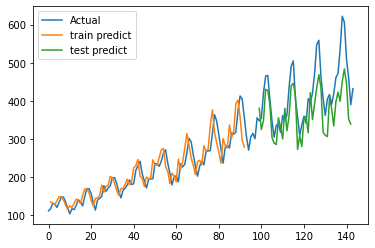

In [45]:
# 训练资料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 测试资料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 绘图
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()

## Stacked LSTM

In [46]:
# 以前期资料为 X，当前期资料为 Y
look_back = 3
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=3).to(device)
train(trainX, trainY)

torch.Size([92, 1])
Epoch: 0, loss: 0.10180
Epoch: 100, loss: 0.00624
Epoch: 200, loss: 0.00335
Epoch: 300, loss: 0.00153
Epoch: 400, loss: 0.00148
Epoch: 500, loss: 0.00145
Epoch: 600, loss: 0.00142
Epoch: 700, loss: 0.00139
Epoch: 800, loss: 0.00137
Epoch: 900, loss: 0.00135
Epoch: 1000, loss: 0.00133
Epoch: 1100, loss: 0.00130
Epoch: 1200, loss: 0.00126
Epoch: 1300, loss: 0.00121
Epoch: 1400, loss: 0.00117
Epoch: 1500, loss: 0.00113
Epoch: 1600, loss: 0.00109
Epoch: 1700, loss: 0.00105
Epoch: 1800, loss: 0.00101
Epoch: 1900, loss: 0.00098


In [47]:
from sklearn.metrics import mean_squared_error
import math 

model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()

# 还原常态化的训练及测试资料
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY.reshape(-1, 1))
print(trainY_actual.shape, trainPredict.shape)

# 计算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(92, 1) (92, 1)
Train RMSE: 15.86
Test RMSE:  65.78


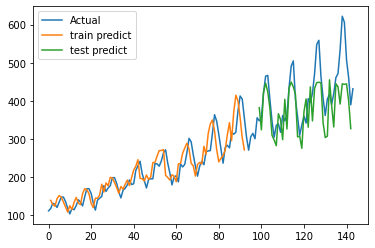

In [48]:
# 训练资料的 X/Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[1:trainPredict.shape[0]+1:, :] = trainPredict

# 测试资料 X/Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]-1:-1, :] = testPredict

# 绘图
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()